In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [ ]:
# %load bike_regression.py
import math
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import cm
from datetime import datetime

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10

df = pd.read_csv('./data/bike_train.csv')

df.columns


def get_days_of_year(date):
    date = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
    new_year_day = datetime(year=date.year, month=1, day=1)
    return (date - new_year_day).days + 1


df['day_of_year'] = df['datetime'].apply(get_days_of_year)
df['hour'] = df['datetime'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").hour)
df['workday'] = df['datetime'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").weekday())

df.describe()
# 1. Define features and Define target
# - define featureas and configure feature columnsA
# - define target
# - define input function


def train_model(learning_rate, steps, batch_size, periods, x_feature, input_features=['hour']):
    steps_per_period = int(steps / periods)
    print('learning_rate', learning_rate)
    print('steps', steps)
    print('steps_per_period', steps_per_period)
    feature_columns = [tf.feature_column.numeric_column(column) for column in input_features]
    X_train = df[input_features]
    target_feature = 'count'
    y_train = df[target_feature]

    def input_fn(X_data, y_data, batch_size=1, repeat=None, shuffle=False):
        X_tensors = {key: np.array(value) for key, value in dict(X_data).items()}
        ds = tf.data.Dataset.from_tensor_slices((X_tensors, y_data))
        ds = ds.batch(int(batch_size)).repeat(repeat)
        if shuffle:
            ds.shuffle(buffer_size=10000)
        X, y = ds.make_one_shot_iterator().get_next()
        return X, y
    # input_fn(X_train, y_train)

    # 2. Define Model
    # - Configure optimizer
    # - Confiture algorithmn
    # - Train the model

    train_input_fn = lambda: input_fn(X_train, y_train, batch_size=batch_size, repeat=100, shuffle=True)
    predict_input_fn = lambda: input_fn(X_train, y_train, batch_size=batch_size, repeat=1, shuffle=False)

    gdo = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    gdo = tf.contrib.estimator.clip_gradients_by_norm(gdo, 5.0)

    linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_columns, optimizer=gdo)

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.ylabel(target_feature)
    plt.xlabel(x_feature)
    sample = df.sample(n=300)
    plt.scatter(sample[x_feature], sample[target_feature])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

    root_mean_squared_errors = []
    for period in range(periods):
        linear_regressor.train(input_fn=train_input_fn, steps=steps_per_period)
        predictions = linear_regressor.predict(input_fn=predict_input_fn)
        predictions = [item['predictions'][0] for item in predictions]
        mean_squared_error = metrics.mean_squared_error(predictions, y_train)
        root_mean_squared_error = math.sqrt(mean_squared_error)
        root_mean_squared_errors.append(root_mean_squared_error)
        print('period: %02d: %0.2f' % (period, root_mean_squared_error))
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % x_feature)[0][0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')[0]
        x_min = sample[x_feature].min()
        x_max = sample[x_feature].max()
        y_min = x_min * weight + bias
        y_max = x_max * weight + bias
        plt.plot([x_min, x_max], [y_min, y_max], c=colors[period])

    # 3. Evalute the Model
    # - Predict
    # - Measure score
    print("RMSE: on traning %0.2f" % root_mean_squared_error)
    result_df = pd.DataFrame({
        'perdiction': pd.Series(predictions),
        'target': df[target_feature]})
    print(result_df.describe())
    print("RMSE: on traning %0.2f" % root_mean_squared_error) 
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')

    plt.plot(np.arange(len(root_mean_squared_errors)), root_mean_squared_errors)
    plt.show()


if __name__ == '__main__':
    def is_interactive():
        import __main__ as main
        return not hasattr(main, '__file__')

    if not is_interactive():
        train_model(
                learning_rate=1e-4,
                steps=1e+6,
                batch_size=1,
                periods=10,
                x_feature='hour',
                input_features=['hour'])


period: 00: 222.81
period: 01: 201.78
period: 02: 190.21
period: 03: 183.32
period: 04: 179.20
period: 05: 176.59
period: 06: 174.93
period: 07: 173.84
period: 08: 173.11
period: 09: 172.59
RMSE: on traning 172.59
       perdiction  target
count     10886.0 10886.0
mean        146.1   191.6
std          85.7   181.1
min           3.0     1.0
25%          77.4    42.0
50%         151.8   145.0
75%         226.1   284.0
max         288.1   977.0
RMSE: on traning 172.59


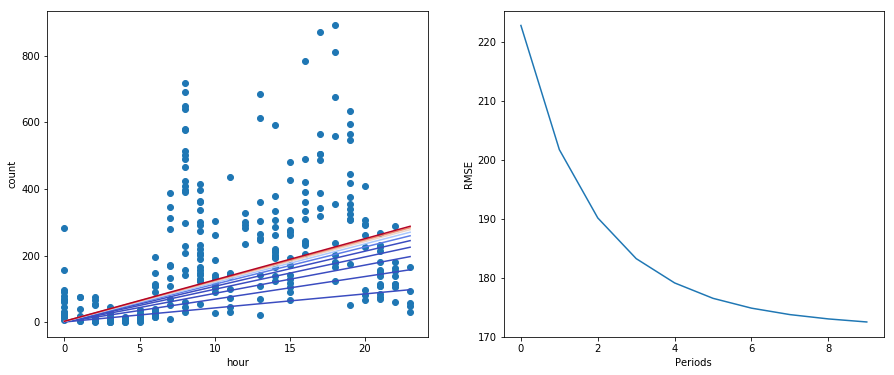

In [6]:
train_model(
        learning_rate=1e-4,
        steps=1e+6,
        batch_size=1e+2,
        periods=10,
        x_feature='hour',
        input_features=['hour'])

period: 00: 263.09
period: 01: 262.53
period: 02: 261.97
period: 03: 261.41
period: 04: 260.85
period: 05: 260.29
period: 06: 259.74
period: 07: 259.18
period: 08: 258.62
period: 09: 258.07
RMSE: on traning 258.07
       perdiction  target
count     10886.0 10886.0
mean          6.3   191.6
std           3.8   181.1
min           0.0     1.0
25%           3.3    42.0
50%           6.6   145.0
75%           9.8   284.0
max          12.5   977.0
RMSE: on traning 258.07


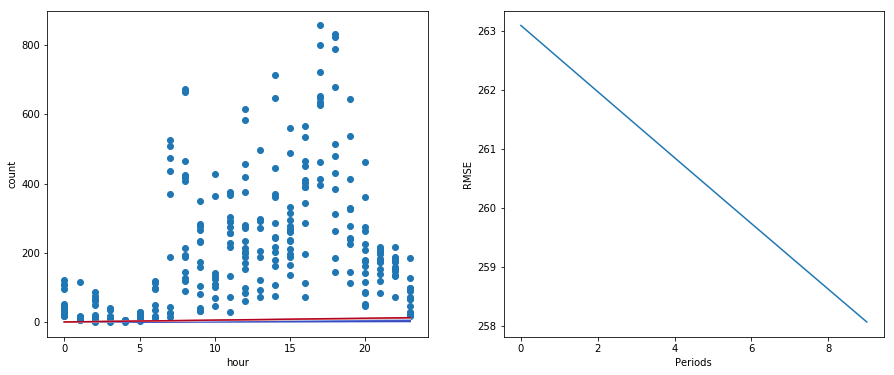

In [10]:
train_model(
        learning_rate=1e-4,
        steps=1e+9,
        batch_size=1e+2,
        periods=10,
        x_feature='hour',
        input_features=['hour'])

period: 00: 258.08
period: 01: 252.61
period: 02: 247.26
period: 03: 242.09
period: 04: 237.11
period: 05: 232.38
period: 06: 227.88
period: 07: 223.62
period: 08: 219.60
period: 09: 215.81
RMSE: on traning 215.81
       perdiction  target
count     10886.0 10886.0
mean         58.8   191.6
std          35.0   181.1
min           0.5     1.0
25%          30.8    42.0
50%          61.2   145.0
75%          91.5   284.0
max         116.8   977.0
RMSE: on traning 215.81


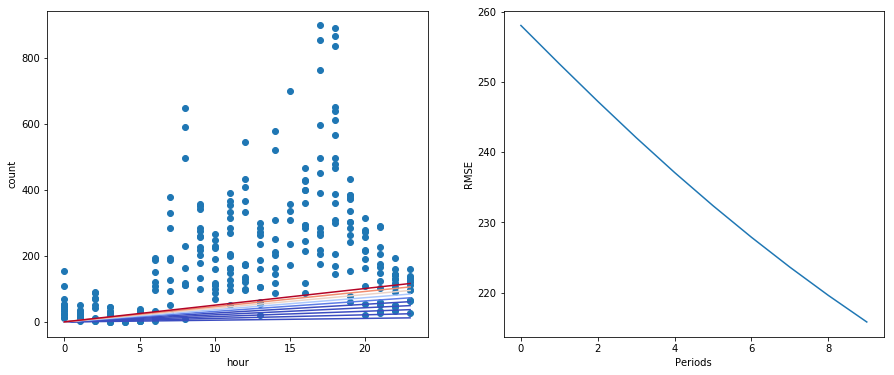

In [12]:
train_model(
        learning_rate=1e-4,
        steps: 1e+9,
        batch_size=10,
        periods=10,
        x_feature='hour',
        input_features=['hour'])

learning_rate 0.1
steps 100000000000
steps_per_period 1000000000
period: 00: 171.82
period: 01: 171.19
period: 02: 171.43
period: 03: 170.24
period: 04: 169.90
period: 05: 170.08
period: 06: 170.37
period: 07: 169.21
period: 08: 170.20
period: 09: 168.91
period: 10: 169.99
period: 11: 168.71
period: 12: 169.83
period: 13: 168.56
period: 14: 169.71
period: 15: 168.45
period: 16: 169.62
period: 17: 168.37
period: 18: 169.55
period: 19: 168.32
period: 20: 169.50
period: 21: 168.29
period: 22: 169.46
period: 23: 168.27
period: 24: 169.42
period: 25: 168.26
period: 26: 169.40
period: 27: 168.24
period: 28: 169.38
period: 29: 168.23
period: 30: 169.36
period: 31: 168.22
period: 32: 169.35
period: 33: 168.21
period: 34: 169.34
period: 35: 168.20
period: 36: 169.33
period: 37: 168.20
period: 38: 169.32
period: 39: 168.19
period: 40: 169.31
period: 41: 168.19
period: 42: 169.31
period: 43: 168.19
period: 44: 169.31
period: 45: 168.18
period: 46: 169.30
period: 47: 168.18
period: 48: 169.30
peri

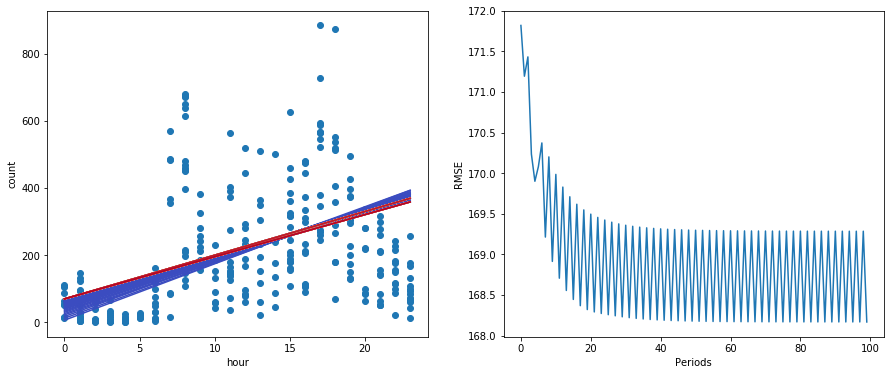

In [30]:
train_model(
        learning_rate=1e-1,
        steps=100000000000,
        batch_size=100,
        periods=100,
        x_feature='hour',
        input_features=['hour'])

learning_rate 0.001
steps 10000000000.0
steps_per_period 100000000
period: 00: 258.07
period: 01: 252.58
period: 02: 247.19
period: 03: 241.90
period: 04: 236.72
period: 05: 231.66
period: 06: 226.73
period: 07: 222.04
period: 08: 217.63
period: 09: 213.52
period: 10: 209.78
period: 11: 206.16
period: 12: 202.81
period: 13: 199.66
period: 14: 196.70
period: 15: 193.88
period: 16: 191.34
period: 17: 189.06
period: 18: 186.98
period: 19: 185.11
period: 20: 183.48
period: 21: 181.96
period: 22: 180.52
period: 23: 179.23
period: 24: 178.03
period: 25: 176.98
period: 26: 176.07
period: 27: 175.28
period: 28: 174.62
period: 29: 174.04
period: 30: 173.51
period: 31: 173.05
period: 32: 172.63
period: 33: 172.24
period: 34: 171.91
period: 35: 171.61
period: 36: 171.33
period: 37: 171.10
period: 38: 170.89
period: 39: 170.71
period: 40: 170.55
period: 41: 170.40
period: 42: 170.27
period: 43: 170.16
period: 44: 170.06
period: 45: 169.97
period: 46: 169.90
period: 47: 169.84
period: 48: 169.79
pe

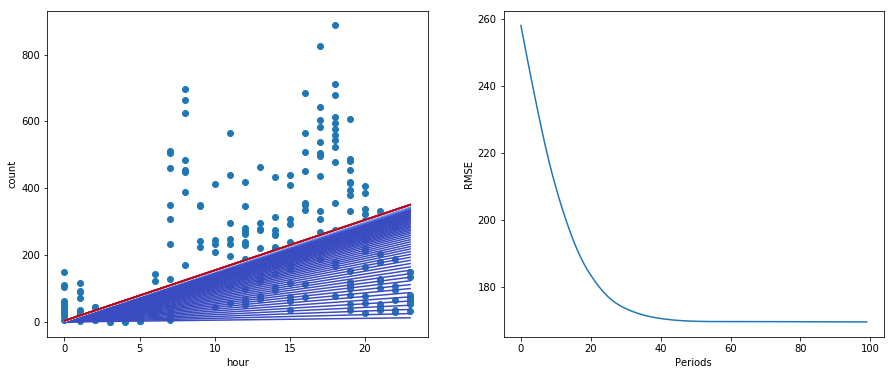

In [33]:
train_model(
        learning_rate=1e-3,
        steps=1e+10,
        batch_size=100,
        periods=100,
        x_feature='hour',
        input_features=['hour'])